# Topic Modeling using Theses' Abstracts
## 5 Implementation and Results
Mai Vu<br>
Helsinki Metropolia University of Applied Sciences<br>
Bachelor’s Thesis<br>
October 2021

In [2]:
#Import libraries
import os 
import re
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#Libraries for lemmatization
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Libraries for topic modeling
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import LdaSeqModel
from gensim.test.utils import datapath

#For plotting
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

### 0 Initial Step

In [3]:
def ReadOutput(cwd):
    u_mass = [None] * 20
    c_v = [None] * 20
    c_uci = [None] * 20
    c_npmi = [None] * 20
    run_time = [None] * 20

    for file in os.listdir(cwd): 
        if file.startswith('gensim_output'): 
            string = open(cwd + "\\" + file)

            for position, line in enumerate(string):
                if 'num_topics' in line:
                    index = int(re.findall(r"[-+]?\d*\.\d+|\d+", line[-5:])[0]) - 1
                elif 'u_mass' in line:
                    u_mass[index] = float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
                elif 'c_v' in line:
                    c_v[index] = float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
                elif 'c_uci' in line:
                    c_uci[index] = float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
                elif 'c_npmi' in line:
                    c_npmi[index] = float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
                elif 'Model finish running in' in line:
                    run_time[index] = int(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
    return u_mass, c_v, c_uci, c_npmi, run_time

In [4]:
def PlotCoherenceMetrics(u_mass, c_v, c_uci, c_npmi):
    plt.figure(figsize = (20, 20)) 

    l = [u_mass, c_v, c_uci, c_npmi]
    xlabels = ['u_mass', 'c_v', 'c_uci', 'c_npmi']

    for i in range(len(l)):
        plt.subplot(4, 1, i + 1)
        plt.plot(l[i], '-o', color = '#434c60')
        plt.xlabel(xlabels[i], fontsize = 18)
        plt.ylabel('value', fontsize = 18)
        plt.xticks(np.arange(len(l[i])), np.arange(1, len(l[i]) + 1))
        plt.grid()
        plt.tight_layout(pad = 3.5)
    plt.show()

In [5]:
#Prepare the corpus for plotting
file = open(os.getcwd() + "\\may27\\data\\final_data", 'rb')
eng_data = pickle.load(file)
file.close()

###Preprocess data
eng_data.sort_values(by = ['year'], inplace = True) #Sort data according to the 'year' column
dates = list(eng_data['year'])

###Tokenization and delete punctuation, number, short words and stop words
eng_stopwords = set(stopwords.words('english')).union(gensim.parsing.preprocessing.STOPWORDS)
lemmatizer = WordNetLemmatizer()
abstracts = []
for abstract in eng_data['en']:
    tokens = []
    for token in nltk.word_tokenize(abstract):
        #Keep abbreviations
        if token.upper() == token and token.isalpha() and len(token) > 1:
            tokens.append(token)
        #Or keep valid words
        else:
            token = token.lower()
            if token.isalpha() and token not in eng_stopwords and len(token) > 3:
                tokens.append(lemmatizer.lemmatize(token))
    abstracts.append(tokens)

del eng_data #Free some data

###Build the bigram
bigram = gensim.models.Phrases(abstracts, min_count = 50, threshold = 10)
for idx in range(len(abstracts)):
    abstracts[idx] = bigram[abstracts[idx]]

###Create dictionary for the given texts
dictionary = corpora.Dictionary(abstracts)
dictionary.filter_extremes(no_below = 50, no_above = 0.25) #Filter words that appear less than 50 documents and more than 25% of all documents

###Create the bag of words for all documents
bag_of_words = [dictionary.doc2bow(abstract) for abstract in abstracts]

#Remove abstracts with too few tokens
token_count = [len(x) for i, x in enumerate(bag_of_words)]
assert len(dates) == len(bag_of_words) # sanity checking...
dates, bag_of_words = zip(*[(dates[i], bag_of_words[i]) for i, x in enumerate(range(len(token_count))) if token_count[i] > 4])

### 5 Implementation

In [6]:
#Get the files
lda_cwd = os.getcwd() + "\\may27"
dtm_cwd = os.getcwd() + "\\june05"

#Read the results
lda_u_mass, lda_c_v, lda_c_uci, lda_c_npmi, lda_run_time = ReadOutput(lda_cwd)
dtm_u_mass, dtm_c_v, dtm_c_uci, dtm_c_npmi, dtm_run_time = ReadOutput(dtm_cwd)

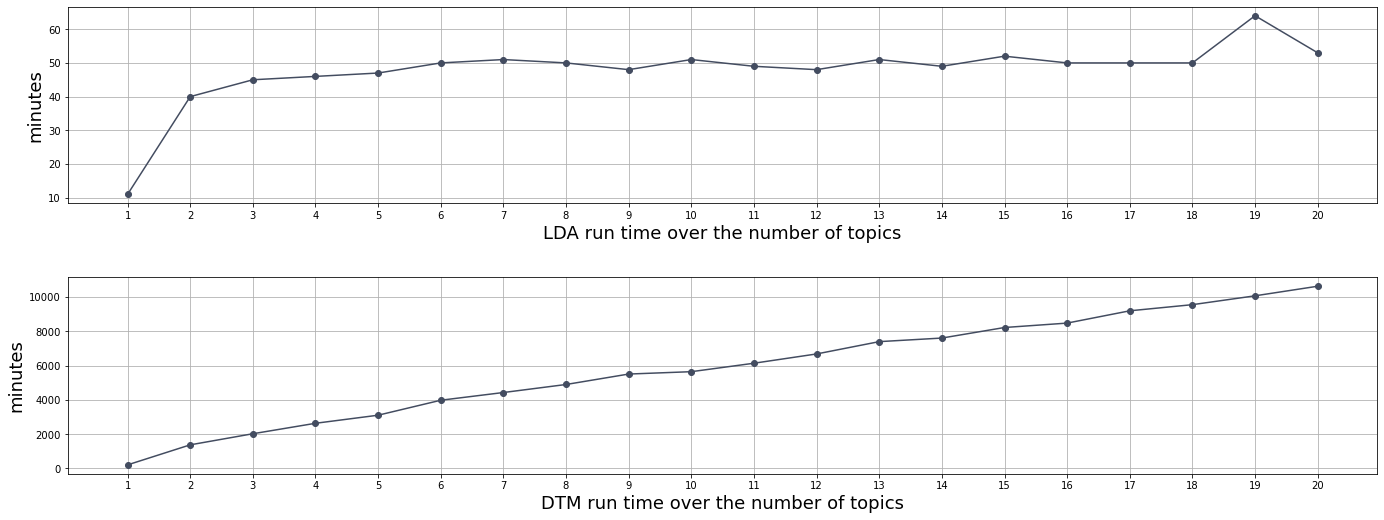

In [7]:
#Compare 2 algorithms running time 
plt.figure(figsize = (20, 8)) 

l = [lda_run_time, dtm_run_time]
xlabels = ['LDA run time over the number of topics', 'DTM run time over the number of topics']

for i in range(len(l)):
    plt.subplot(2, 1, i + 1)
    plt.plot(l[i], '-o', color = '#434c60')
    plt.xlabel(xlabels[i], fontsize = 18)
    plt.ylabel('minutes', fontsize = 18)
    plt.xticks(np.arange(len(l[i])), np.arange(1, len(l[i]) + 1))
    plt.grid()
    plt.tight_layout(pad = 3.5)
#plt.savefig('RunTime.png')
plt.show()

#### 5.1 LDA Model

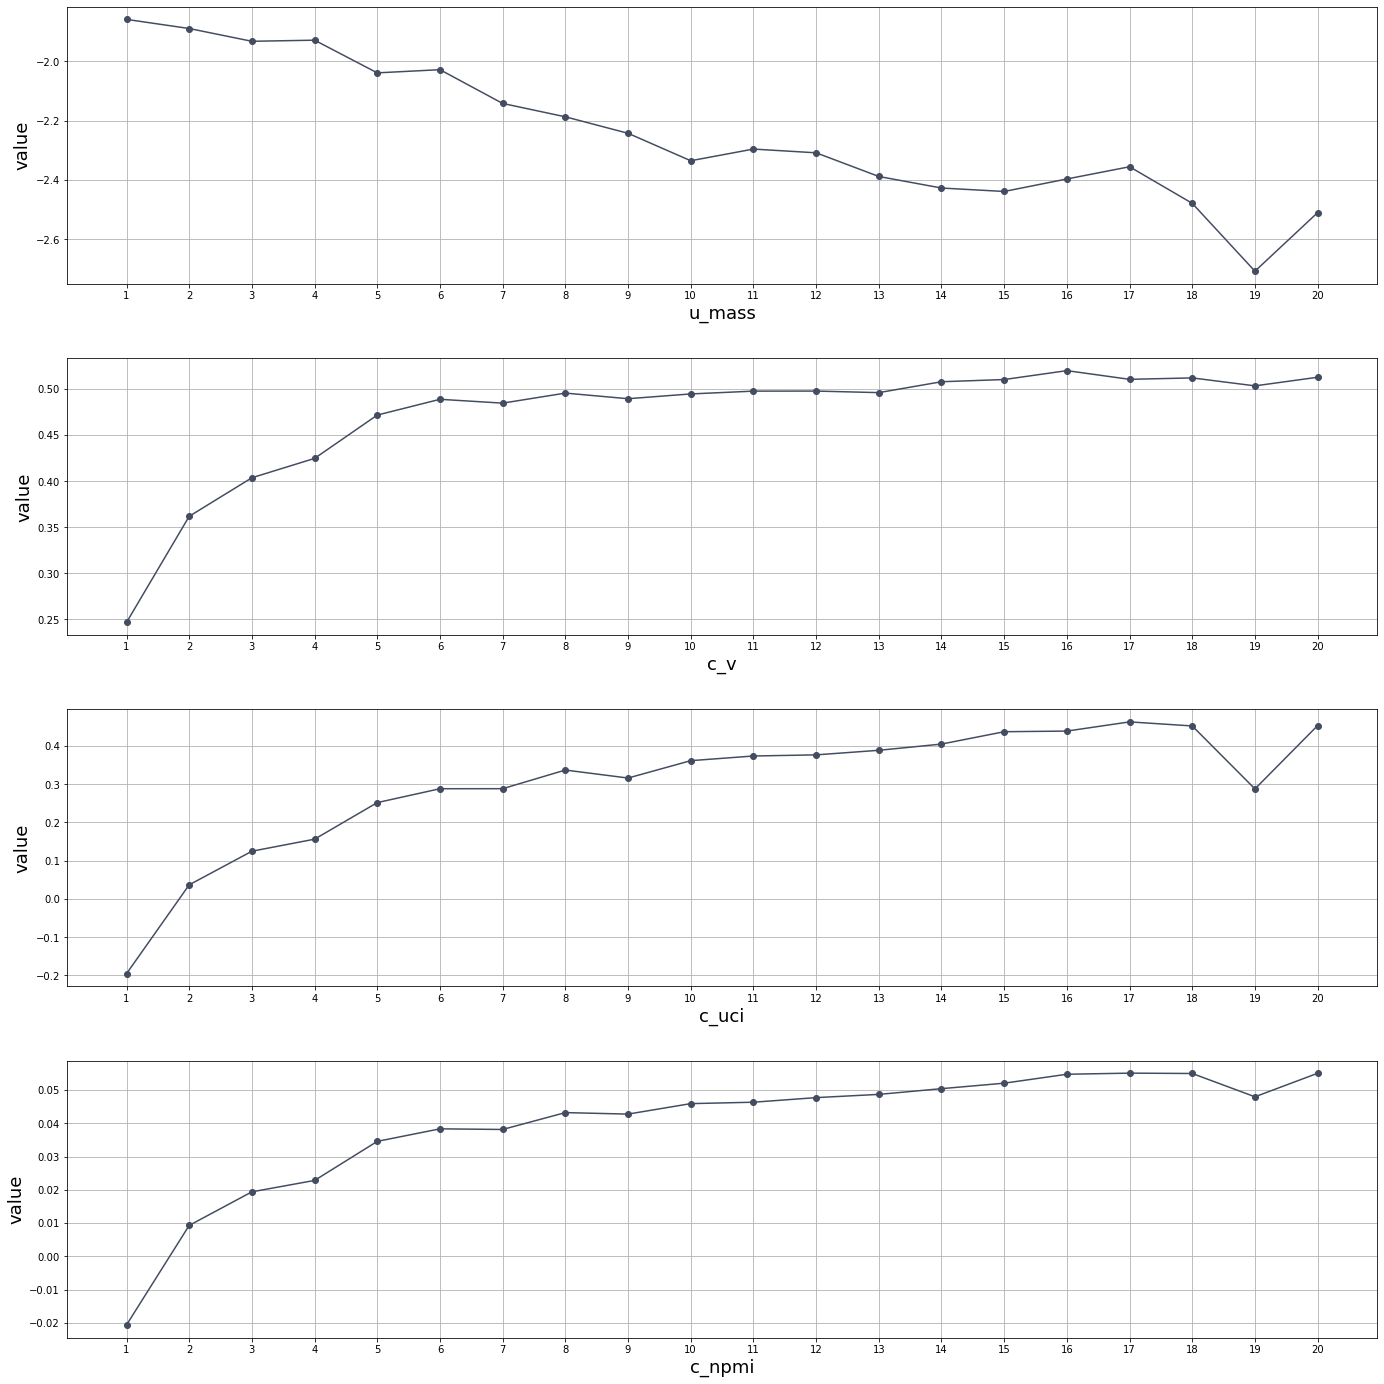

In [8]:
#Plot 4 coherence metrics of the LDA models
PlotCoherenceMetrics(lda_u_mass, lda_c_v, lda_c_uci, lda_c_npmi)

In [9]:
def PlotKeywords(LDA_model, num_topic, num_word = 7):
    """Function to plot important keywords.
    
    Args:
        (LdaModel) LDA_model: the given LDA model.
        (integer) num_topic: number of topics of the model.
        (integer) num_word: number of words to plot.

    Returns:
        None.
    """
    keywords = [[word for word, _ in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]
    keywords_prob = [[beta for _, beta in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]

    gs = gridspec.GridSpec(round(math.sqrt(num_topic)) + 1, round(math.sqrt(num_topic)) + 1)
    gs.update(wspace = 0.5, hspace = 0.3)
    plt.figure(figsize = (20, 15))
    for i in range(num_topic):
        ax = plt.subplot(gs[i])
        plt.barh(range(num_word), keywords_prob[i][:num_word], color = '#434c60')
        ax.invert_yaxis()
        ax.set_yticks(range(num_word))
        ax.set_yticklabels(keywords[i][:num_word])
        plt.grid()
        plt.title("Topic " + str(i + 1))

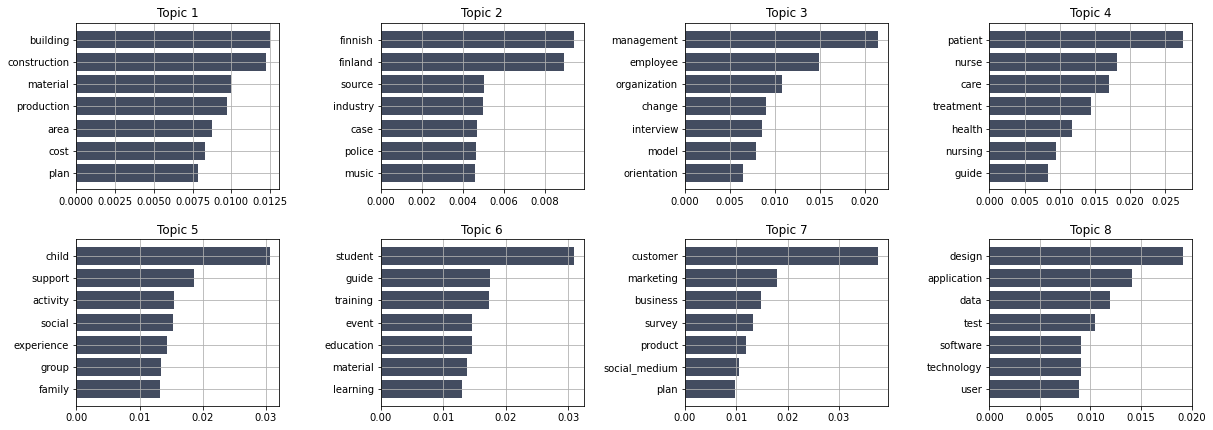

In [10]:
#Topic Plotting
num_topic = 8
path = lda_cwd + "\\results\\lda_model_" + str(num_topic) + "topics.dat"
lda = LdaModel.load(datapath(path), mmap = 'r')
lda_dict = corpora.Dictionary.load(datapath(path + ".id2word"), mmap = 'r')
PlotKeywords(lda, num_topic)
#display = gensimvis.prepare(lda, bag_of_words, lda_dict, sort_topics = False)
#pyLDAvis.display(display)